In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch
import torch.nn.functional as F
from torch import nn

import safetensors
from accelerate import notebook_launcher

from utils.data_utils import BrainDataset, get_tokenizer
from utils.train_utils import TrainConfig, run_train_model, count_parameters, load_model_weights

from dataclasses import dataclass
from simple_parsing.helpers import Serializable

from safetensors.torch import load_model
import albumentations as A

import matplotlib.pyplot as plt
from dataclasses import dataclass
import gc

c:\Users\peter\alvi\brain2text\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.brain_mae import EncoderConfig, Encoder, MAE, MAEConfig

## Init brain module

In [3]:
@dataclass
class EncoderConfig(Serializable):
    # data params
    window_size: int = 32
    n_electrodes: int = 256
    patch_size: int = 4

    n_layers: int = 12
    dim: int = 512
    hidden_dim: int = 2048

    head_dim: int = 32
    n_heads: int = 16
    n_kv_heads: int = 16 # now it should be the same with n_heads.

@dataclass
class MAEConfig(Serializable):
    masking_ratio: float = 0.75

    # data params
    n_layers: int = 12
    dim: int = 256
    hidden_dim: int = 1024

    head_dim: int = 16
    n_heads: int = 16
    n_kv_heads: int = 16 # now it should be the same with n_heads.


## Init language model

In [4]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

In [5]:
encoder_config = EncoderConfig()
mae_config = MAEConfig()
model = MAE(encoder_config=encoder_config, mae_config=mae_config)

EncoderConfig(window_size=32, n_electrodes=256, patch_size=4, n_layers=12, dim=512, hidden_dim=2048, head_dim=32, n_heads=16, n_kv_heads=16)
Simple Encoder: number of parameters: 50.50M
MAEConfig(masking_ratio=0.75, n_layers=12, dim=256, hidden_dim=1024, head_dim=16, n_heads=16, n_kv_heads=16)
MAE: number of parameters: 63.74M


In [6]:
window_size = encoder_config.window_size
n_electrodes = 256

train_transform = A.Compose([
    
    # A.CoarseDropout(fill_value=0, p=0.5),
    # A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),
    # A.GaussNoise(var_limit=0.005, mean=0, p=0.5),

    # A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
    #               border_mode=0, value=0, always_apply=True),
    A.RandomCrop(height=window_size, width=n_electrodes, always_apply=True),
    # A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True),

])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
                  border_mode=0, value=0, always_apply=True),
    A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True)
])


data_path = Path(r'C:\Users\peter\alvi\brain2text\competitionData')
train_dataset = BrainDataset(data_path / 'train', tokenize_function=get_tokenizer(tokenizer), transform=train_transform)
test_dataset = BrainDataset(data_path / 'test', tokenize_function=get_tokenizer(tokenizer), transform=test_transform)

Runed processing of the  C:\Users\peter\alvi\brain2text\competitionData\train
len of the dataset: 8780
max signal size: 906 | max tokens size: 24
median signal size: 297.0 | median tokens size: 10.0
Runed processing of the  C:\Users\peter\alvi\brain2text\competitionData\test
len of the dataset: 880
max signal size: 919 | max tokens size: 21
median signal size: 285.0 | median tokens size: 10.0


In [7]:
# del tokenizer
# gc.collect()

In [8]:
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# x, y, date = next(iter(test_dataloader))
# print(x.shape, y.shape, date.shape)

# loss, logits = model(x, y, date)


# Work with data

In [9]:
# project_name = 'brain_mae'
# save_folder = Path("logs/chizhov/brain_mae")

# train_config = TrainConfig(exp_name='brain-mae-test-one',
#                            mixed_precision=True,
#                            batch_size=128, 
#                            grad_accum=8,
#                            num_workers=2,
#                            pin_memory=True, 
#                            eval_interval=250, 
#                            learning_rate=1e-3, # 1e-5
#                            weight_decay=0, 
#                            grad_clip=5, #1
#                            lr_decay_iters=20_000, 
#                            warmup_iters=1000, 
#                            project_name=project_name, 
#                            save_folder=save_folder
#                           )


# args = (model, (train_dataset, test_dataset), train_config, encoder_config)
# notebook_launcher(run_train_model, args, num_processes=1)

In [10]:
import matplotlib.pyplot as plt
from utils.train_utils import load_model_weights 

model = load_model_weights(model, r'C:\Users\peter\alvi\brain2text\frankenstein\notebooks_trainer\logs\chizhov\brain_mae\brain_mae\brain-mae-test-one\step_6000_loss_0.0183.safetensors')

load default weights


In [29]:
model.masking_ratio = 0.5

In [30]:
with torch.no_grad(): 
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

    x, y, date = next(iter(test_dataloader))

    print(x.shape, y.shape, date.shape)
    model = model.to('cuda')
    losses, reconstruction_signal, binary_mask = model(x.to('cuda'), y.to('cuda'), date.to('cuda'), return_preds=True)

torch.Size([16, 32, 256]) torch.Size([16, 25]) torch.Size([16, 1])
torch.Size([16, 2048, 4])
torch.Size([16, 2048, 4])


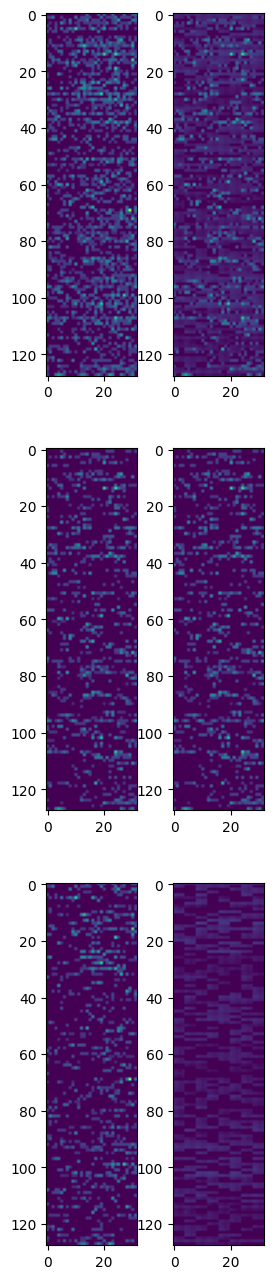

In [34]:
recon = reconstruction_signal.cpu().detach()
binary_mask = binary_mask.cpu().detach().to(torch.bool)
x = x.cpu().detach()

x_masked_input = binary_mask * x
x_unmasked_input = ~binary_mask * x

recon_masked = binary_mask * recon
recon_unmasked = ~binary_mask * recon


t_st, t_end = 0, 32
c_st, c_end = 0, 128

fig, ax = plt.subplots(3,2, figsize = (3, 16))
ax[0, 0].imshow(x[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[1, 0].imshow(x_unmasked_input[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[2, 0].imshow(x_masked_input[0, t_st:t_end, c_st:c_end].T, vmax=1)

ax[0, 1].imshow(recon[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[1, 1].imshow(recon_unmasked[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[2, 1].imshow(recon_masked[0, t_st:t_end, c_st:c_end].T, vmax=1)